## 0. Basic Packages

In [1]:
import pandas as pd
#Set copy warning to off
pd.set_option('mode.chained_assignment', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

##### We import all the functions used in the previous notebooks

In [2]:
from nlp_preprocess import *

##### We add accents to stop_words and exclude the words we want

In [3]:
from nltk.corpus import stopwords

#we select the spanish stop words (by default all the words with accents have them)
stop_words = stopwords.words('spanish')

#now we have the words with accents and the same ones without accents
stop_words = add_non_accents(stop_words)

#list to exclude in stop_words (excluded based in "count_stop_words" fn)
stop_w_list = ["no", "mucho", "muchos", "tiene", "tienen", "otras", "sin", "nada", "algo"
               "tanto", "alguna", "estamos", "tengan", "tenemos", "nuestros", "fuera", "algunos", "hasta"]

#exclude previous list of words from stop_words
stop_words.difference_update(stop_w_list)

## 1. Data Wrangling

In [4]:
f1 = pd.read_excel("comments.xlsx", [0])[0]
f2 = pd.read_excel("comments.xlsx", [1])[1]

df = pd.concat([f1, f2]) 
df.rename(columns={"Initial Classification":"Initial_Classification"}, inplace=True)
print(df.shape)
df.head()

(584, 4)


,ID,Area,Comment,Initial_Classification
0,1,Dept 1,Cerrar la brecha entre los que deciden el trab...,Negativo
1,3,Dept 1,"Sobretodo, que se miren las cargas de trabajo ...",Negativo
2,4,Dept 1,1. Dar coaching a algunos Gerentes (que no sab...,Negativo
3,19,Dept 1,s,Negativo
4,29,Dept 1,Mas oportunidades de crecimiento y major salar...,Negativo


### Checking for nulls

In [5]:
#cecking for nulls
df.isna().sum()

ID                         0
Area                       0
Comment                   11
Initial_Classification     0
dtype: int64

In [6]:
#checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 291
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      584 non-null    int64 
 1   Area                    584 non-null    object
 2   Comment                 573 non-null    object
 3   Initial_Classification  584 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.8+ KB


In [7]:
#cheking the null comments
df[df.Comment.isna()]

,ID,Area,Comment,Initial_Classification
12,120,Dept 1,NaN,Negativo
48,561,Dept 4,NaN,Negativo
109,1280,Dept 7,NaN,Negativo
129,1475,Dept 9,NaN,Negativo
158,1768,Dept 9,NaN,Negativo
227,2481,Dept 9,NaN,Negativo
240,2587,Dept 9,NaN,Negativo
274,2850,Dept 10,NaN,Negativo
277,2887,Dept 10,NaN,Negativo
227,2481,Dept 9,NaN,Positivo


### Updating nulls with NA

In [8]:
#we will replace with the term "NA"
df.Comment[df.Comment.isna()] = "NA"

### Lowering comments

In [9]:
df.Comment = df.Comment.str.lower()

## 2. Preprocess

### Detecting language

In [10]:
#we create a new column with the detected lang
#choose between langdetect or cld3. By default cld3, which works bettter (for es)
df["language"] = dect_lang(df.Comment, detector="langdetect")

In [11]:
#we check the non-snpanish ones
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: s ----> Lang: sv
Sentence: prefiero no comentar ----> Lang: it
Sentence: na ----> Lang: tl
Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: no cambiaria nada. ----> Lang: pt
Sentence: ninguna. ----> Lang: tl
Sentence: los salarios justos  ----> Lang: lt
Sentence: nada ----> Lang: so
Sentence: mejorar la paga ----> Lang: id
Sentence: na ----> Lang: tl
Sentence: no cambiaria nada. ----> Lang: pt
Sentence:

Once we have checked the previous output we can see the english comments are well identified, and the rest are either, errors / sentences with no meaning, or spanish sentences identified as catalan, italian or other language

Therefore it is fair to consider, non-english comments as spanish comments in this case

In [12]:
#we replace non-english comments for "es" term
df.language[df.language!="en"] = "es"

In [13]:
#we re-check the list again
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: nothing specific ----> Lang: en
Sentence: some businesses within la empresa should be evaluated/treated differently than the rest of the company... because they are vey different in nature. employees / businesses should not be punished for situations that occurred more than 10 years ago under very different industry/market conditions.  ----> Lang: en
Sentence: most

### Creating Dataframe for each Language

In [14]:
df_es = df[df.language=="es"]
df_en = df[df.language=="en"]

### Positive vs Negative Comments, Preprocess & Clean

In [15]:
#separate comments by type
neg_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Negativo"]
pos_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Positivo"]

#clean comments
n_clean_comments_es = clean_comments(neg_comments_es)
p_clean_comments_es = clean_comments(pos_comments_es)


#1. set root to "no" if you don't want the root (lemma) of the word, but the original world (default="yes")
#2. set stop_w to "yes" if you want to include stop_words (default="no")
n_pre_comments_es = preprocess(n_clean_comments_es, root="no", stop_w="no", stop_words=stop_words)
p_pre_comments_es = preprocess(p_clean_comments_es, root="no", stop_w="no", stop_words=stop_words)

#flatten comments in a list
n_flatten_comments_es = [" ".join(comments) for comments in n_pre_comments_es]
p_flatten_comments_es = [" ".join(comments) for comments in p_pre_comments_es]

## 3. Topic Modeling

In [ ]:
tokens = input("Select between the group of comments\n'n_flatten_comments_es' (negative)\n'p_flatten_comments_es' (positive)\n")

while tokens != "n_flatten_comments_es" and tokens != "n_flatten_comments_es":
    tokens = input("Select between the one of them")
    
if tokens == "n_flatten_comments_es":
    tokens = n_flatten_comments_es
elif tokens == "p_flatten_comments_es":
    tokens = p_flatten_comments_es

In [16]:
from top2vec import Top2Vec

topic_model = Top2Vec(documents=tokens, embedding_model='universal-sentence-encoder',
                min_count=1, speed="deep-learn", workers=8, verbose=True)

2020-12-30 14:28:41,219 - top2vec - INFO - Pre-processing documents for training
2020-12-30 14:28:41,238 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
2020-12-30 14:28:45,537 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2020-12-30 14:28:45,838 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2020-12-30 14:28:52,088 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2020-12-30 14:28:52,102 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [17]:
topic_size, n_topics = topic_model.get_topic_sizes()
print("Topic sizes", topic_size, "Number of topics", n_topics)

Topic sizes [148  93] Number of topics [0 1]


In [18]:
#funtion to get words per topic, word score, and topics
topics_words, words_score, topics = topic_model.get_topics(len(n_topics))
print("Words per topic (a topic is an array)", topics_words)
print()
print("Words score", words_score)
print()
print("Topics", topics)

Words per topic (a topic is an array) [['puede' 'pues' 'ayuda' 'lider' 'creo' 'buen' 'mejor' 'alguien' 'veces'
  'excelente' 'diferencia' 'igual' 'algunos' 'menos' 'buscar'
  'trabajando' 'funciona' 'analisis' 'demasiado' 'puntos' 'bajo'
  'sistemas' 'apoyo' 'entiendo' 'cambiar' 'tienen' 'grupos' 'tiene'
  'claro' 'cosas' 'aqui' 'informacion' 'experiencia' 'remoto' 'hacen'
  'prefiero' 'buena' 'acuerdo' 'perspectiva' 'mejores' 'primero'
  'dificil' 'pueden' 'caso' 'estamos' 'seguro' 'deberia' 'crear' 'titulo'
  'resultado']
 ['alguien' 'ayuda' 'funciona' 'veces' 'mejor' 'puede' 'pues' 'excelente'
  'aqui' 'cambiar' 'creo' 'lider' 'trabajando' 'buen' 'diferencia'
  'seguro' 'sistemas' 'analisis' 'buscar' 'informacion' 'igual' 'nunca'
  'apoyo' 'experiencia' 'demasiado' 'problemas' 'primero' 'menos' 'claro'
  'caso' 'deberia' 'puntos' 'titulo' 'cambios' 'segun' 'trabajo'
  'algunos' 'requisitos' 'crear' 'cierto' 'tienen' 'resultados' 'encima'
  'perspectiva' 'paga' 'empresa' 'grupos' 'pr

In [19]:
#function to check the docs based in a keyword, docs score (related with the keyword) and docs IDs
topic_model.search_documents_by_keywords(["salario"], 10)[0]

array(['salario competitivo', 'mejorar infraestructuras',
       'igualdad salarial', 'comunicacion efectiva',
       'oportunidades_crecimiento major salario', 'mejorar paga',
       'mejorar paga', 'mejores ingresos', 'incrementar salarios',
       'mejorar salarios empleados'], dtype=object)

In [20]:
#function to get documents base in a topic
for i, t in enumerate(topics):
    print("Topic number ", i, "\n", topic_model.search_documents_by_topic(t, 10)[0], "\n")

Topic number  0 
 ['mejorar carga trabajo cada empleado tener igualdad'
 'mejor paridad salario empleados'
 'flexibilidad monitoreo llamadas caso empleado cobros entiendo sueldo devengamos debe par trabajo hacemos responsabilidad tenemos empresa'
 'tratar empleados adultos darles oportunidad hacer trabajo propio criterio'
 'mejor orientacion empleado dentro unidad trabajo'
 'distribuir mejor tareas empleados' 'hace dificil pensar pueden mejorar'
 'mejor salario empleados' 'menos reuniones menos presion hacia empleados'
 'tomar cuenta experiencia estudios comprobado'] 

Topic number  1 
 ['oportunidades_crecimiento queremos solicitar plaza entendemos cumplimos requisitos nivel professional educativo no idioma deben ser flexibles entrevistar accede plataformas solicitud plazas siempre llega email no cumplo requisitos llevo años empresa bachillerato completado no issues expediente opaquen empleada entiendo desmotiva mucho empleados tener ganas crecer aprender cosas nuevas tan siquiera pue

[None, None]

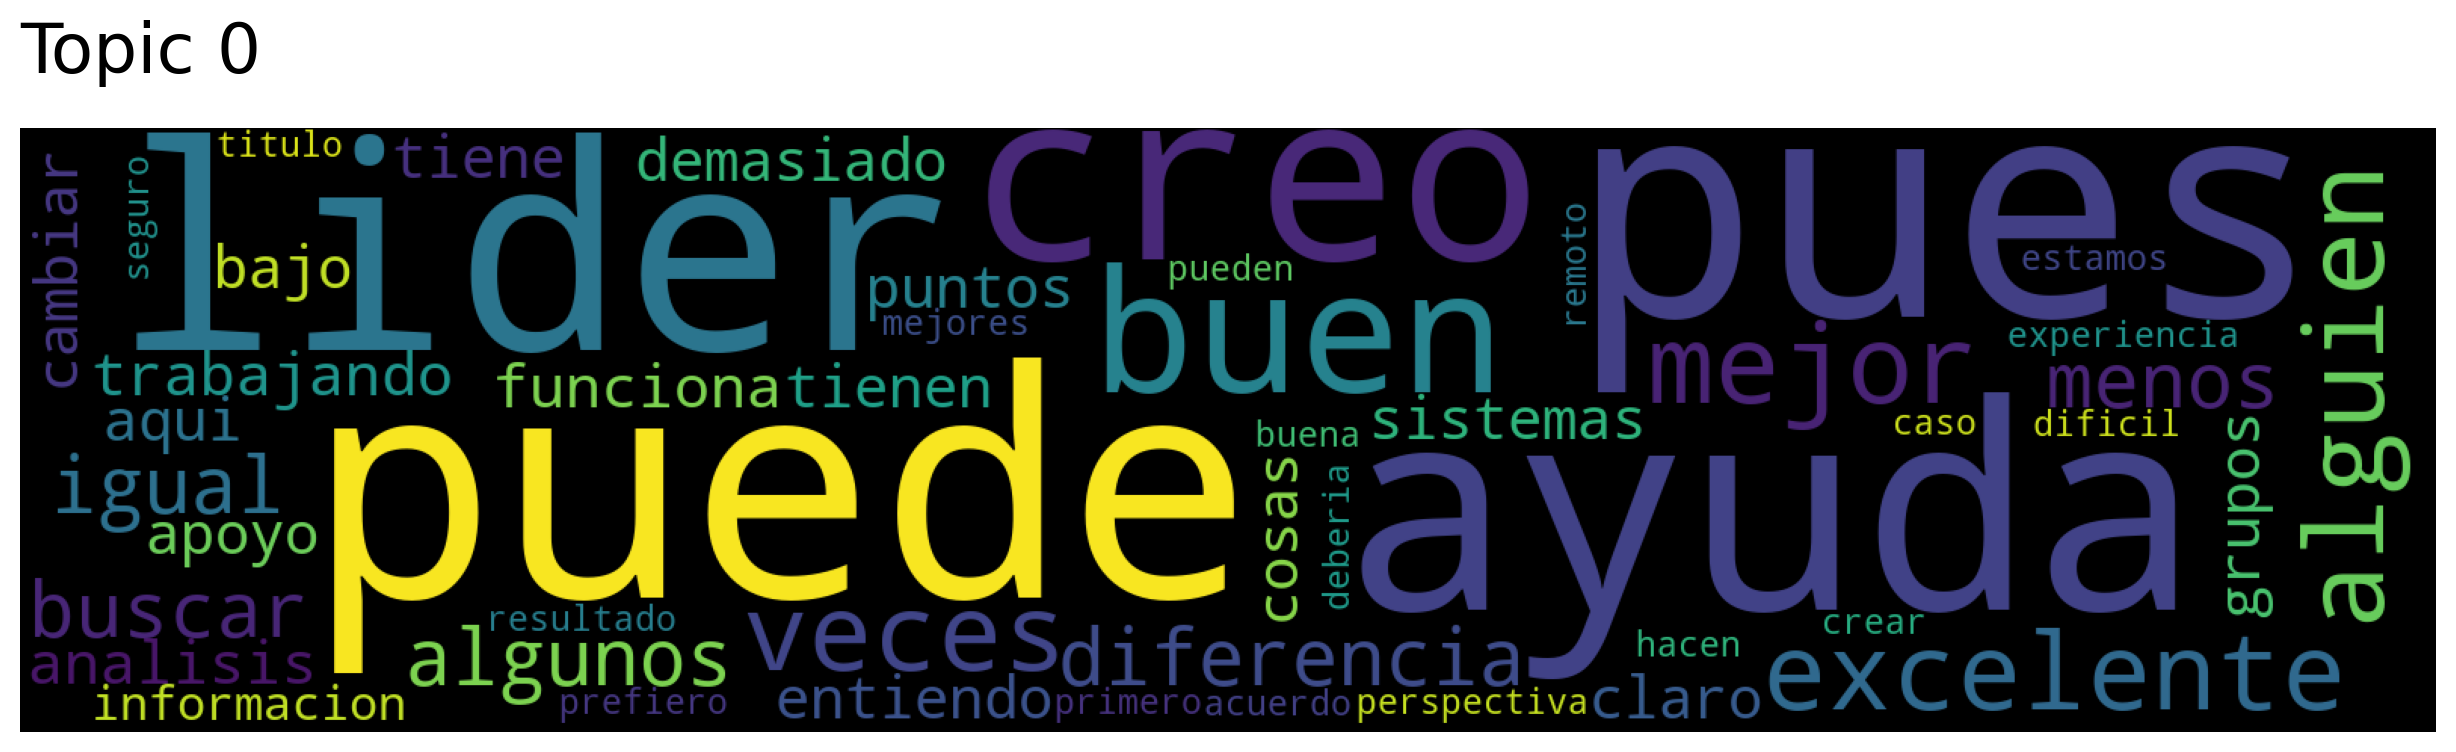

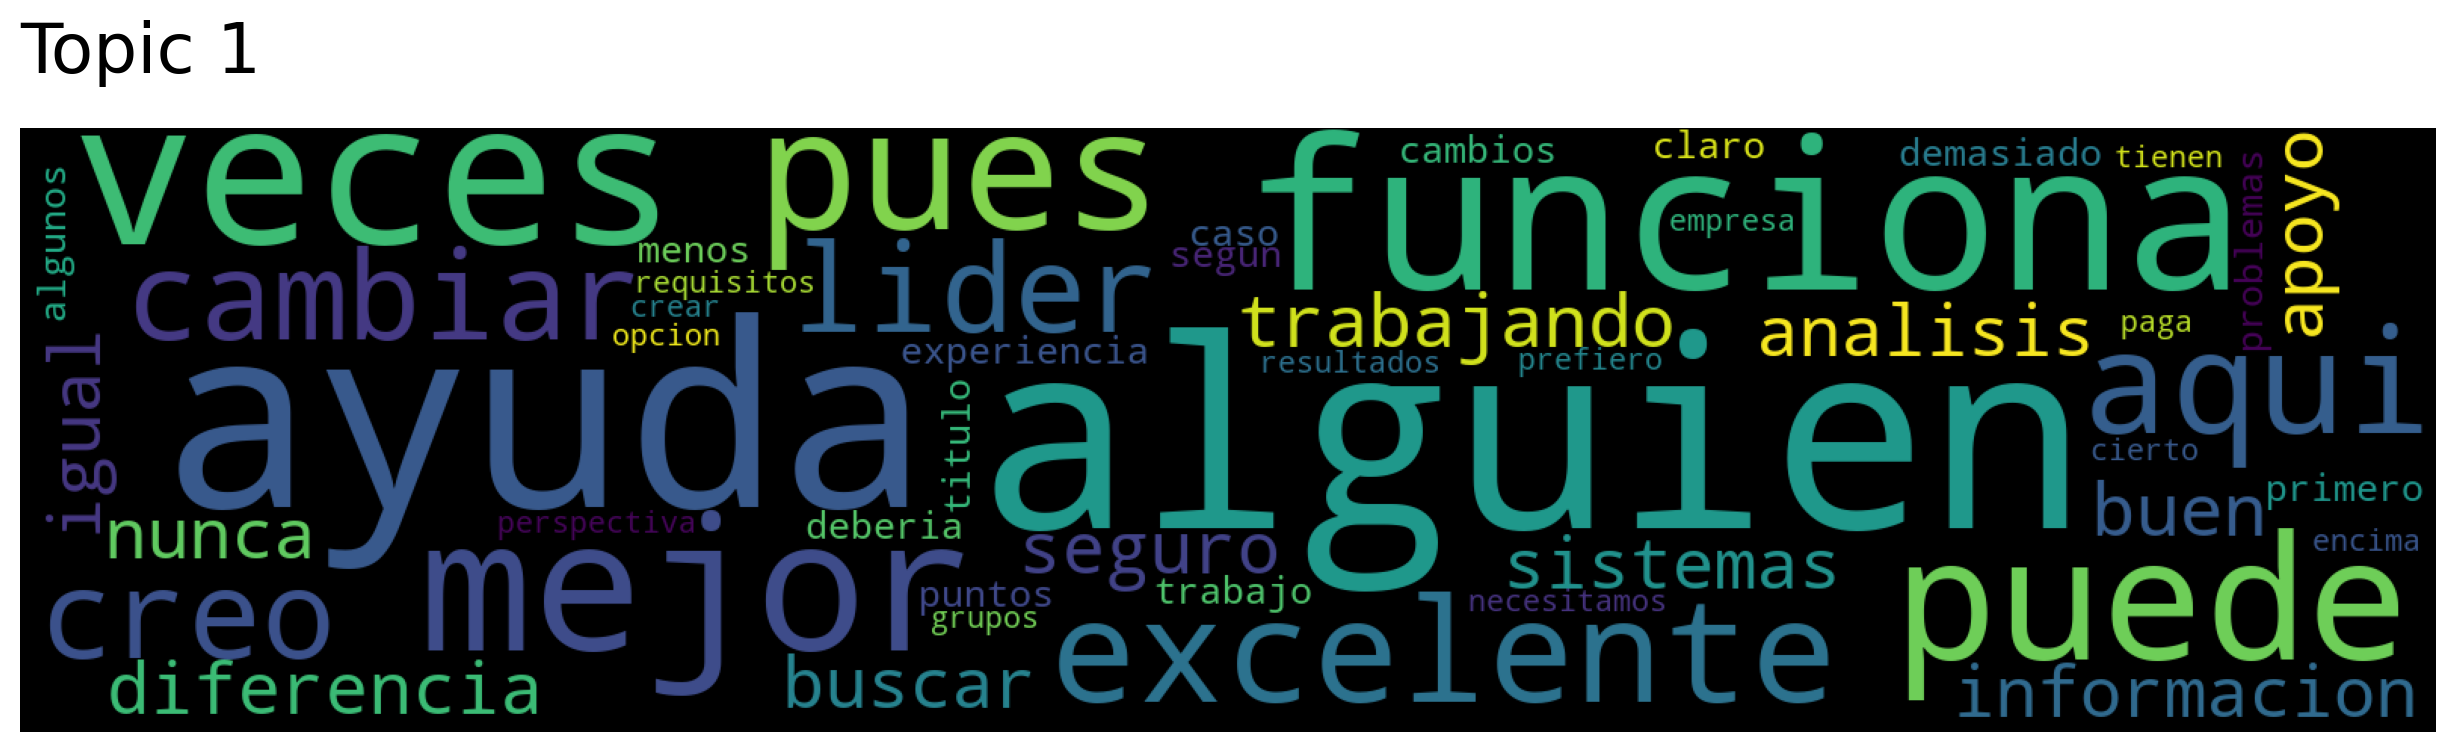

In [21]:
[topic_model.generate_topic_wordcloud(n) for n in n_topics]